In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import pandas as pd
from utils import ml_models, stochastic_processes, power_functions, data_prep


custom_dtype='float64'
tf.keras.backend.set_floatx(custom_dtype)


# Loading data

In [ ]:
# Prepare target/feature data and initial conditions Z
freq, features = data_prep.load_data()
ts, dfs = data_prep.prepare_data(freq, features, custom_dtype=custom_dtype)

# Stochastic processes

## Aggregate swing equation with a single Sawtooth power imbalance

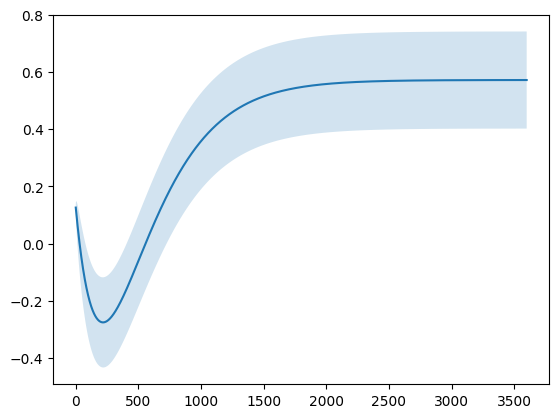

In [3]:
sp_sawtooth = stochastic_processes.SOSawtooth(ts)

params_mean = [[0.,0.126],144, 290,-0.0038,0.0000068]
params_sigma = [[0.000001,0.00000001,0.01], 144, 290, 0.02]

sp_means = sp_sawtooth.mean_t(*params_mean)[0]
sp_stds = sp_sawtooth.sigma_t(*params_sigma)[0]

plt.plot(ts, sp_means)
plt.fill_between(ts, sp_means-sp_stds, sp_means+sp_stds, alpha=0.2)

100%|██████████| 1/1 [00:00<00:00, 158.80it/s]


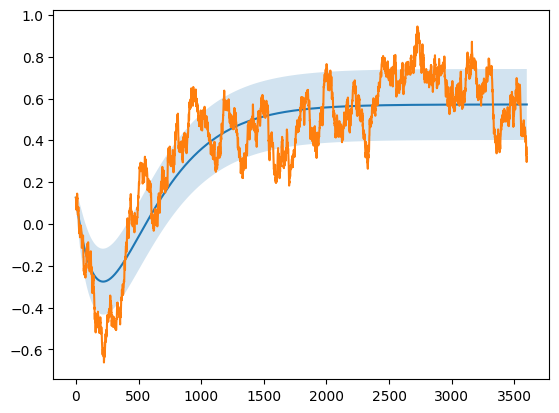

In [4]:
rand_sample = sp_sawtooth.generate_sample(params_in=np.array([[0.,0.126,0.000001,0.00000001,0.01, 144, 290,0.02,-0.0038,0.0000068]]))[0]

plt.plot(ts, sp_means)
plt.fill_between(ts, sp_means-sp_stds, sp_means+sp_stds, alpha=0.2)
plt.plot(ts, rand_sample)

## Aggregate swing equation with arbitrary power imbalance

### Zero power step

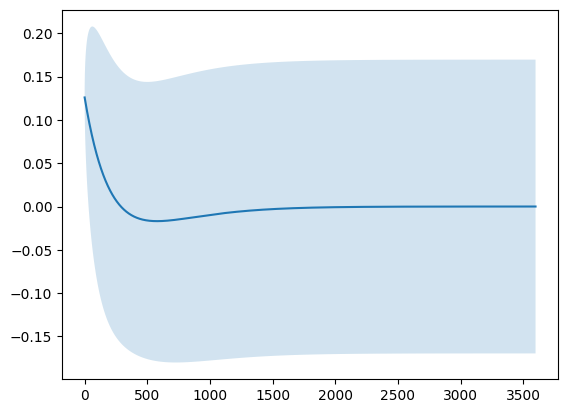

In [5]:
sp_power_func = stochastic_processes.SOPowerStep(ts, power_step=power_functions.ZeroPowerStep())

params_mean = [[0.,0.126],144, 290,[]]
params_sigma = [[0.000001,0.00000001,0.01], 144, 290, 0.02]

sp_means = sp_power_func.mean_t(*params_mean)[0]
sp_stds = sp_power_func.sigma_t(*params_sigma)[0]

plt.plot(ts, sp_means)
plt.fill_between(ts, sp_means-sp_stds, sp_means+sp_stds, alpha=0.2)

### Example of defining a custom power imbalance

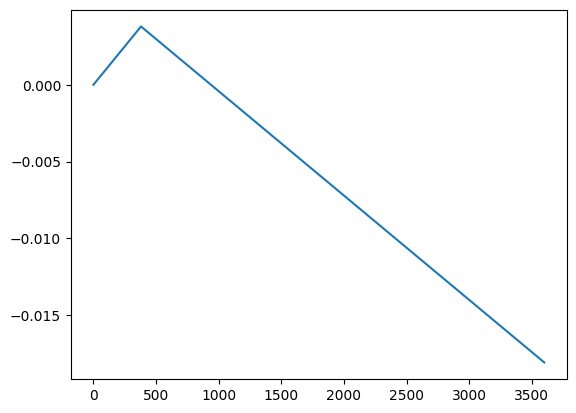

In [6]:
class RampDrift():
    
    def __init__(self, costum_dtype):
        
        self.n_params = 3
        self.dtype = costum_dtype
        self.param_names = ['q', 'r', 's']
        
    def constraints(self,inputs, scalings=1):
        
        return tf.stack([tf.math.softplus(inputs[...,0])*tf.math.sign(inputs[...,2]),
                         -tf.math.softplus(inputs[...,1])*tf.math.sign(inputs[...,2]),
                         inputs[...,2]], axis=-1)*scalings
    
    def apply(self, t, q, r, s):

        ramp = s*t*tf.cast(t<q/s, self.dtype)
        drift = (r*(t-q/s)+q)*tf.cast(t>=q/s, self.dtype)
        
        return ramp + drift
    


power_step = RampDrift('float64')
plt.plot(ts, power_step.apply(ts,0.0038,-0.0000068, 0.00001))

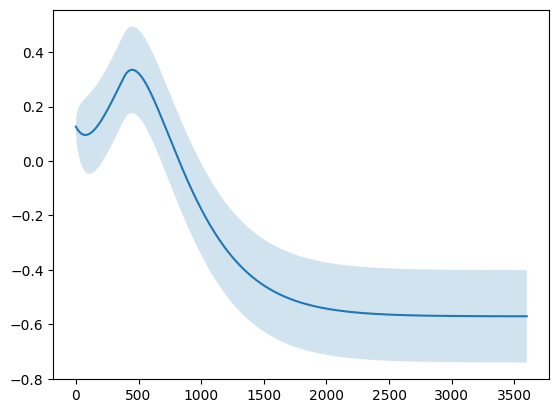

In [8]:
sp_power_func = stochastic_processes.SOPowerStep(ts, 
                                                 power_step=power_step,
                                                 dt_ratio=10)

params_mean = [[0.,0.126],144, 290,[0.0038,-0.0000068, 0.00001]]
params_sigma = [[0.000001,0.00000001,0.01], 144, 290, 0.02]

sp_means = sp_power_func.mean_t(*params_mean)[0]
sp_stds = sp_power_func.sigma_t(*params_sigma)[0]

plt.plot(ts, sp_means)
plt.fill_between(ts, sp_means-sp_stds, sp_means+sp_stds, alpha=0.2)

# PIML models: Predict frequency probability from features

## Fit model

In [9]:
def negloglik(p, rv_p):
    return -rv_p.log_prob(p)

hps = data_prep.prepare_fixed_hps(features=dfs['X_train'], ts=ts,
                                              power_step= RampDrift(custom_dtype),
                                              param_scalings=[1,0.01,0.1,100,100,0.01,0.001,0.001,0.001,0.001, 0.000001],
                                              vmins=[0.001, 0, 0.001, 10, 30, 0.0001, 0,0,0,0,0])
hps.keys()

dict_keys(['param_scalings', 'power_step', 'vmin', 'ts', 'feature_mean', 'feature_var'])

In [117]:
piml_model = ml_models.SOModel(**hps, 
                               dropout_rate=0.1, list_of_units= [128, 64, 32],
                               activation_func= 'sigmoid')
piml_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                   loss=negloglik)
                    #, run_eagerly=True) -> for debugging!!!
piml_model.fit([dfs['X_train'], dfs['Z_train']],
               dfs['y_train'],
               epochs=10)

Epoch 1/10
2947/2947 [==============================] - 33s 10ms/step - loss: -616.0651
Epoch 2/10
2947/2947 [==============================] - 29s 10ms/step - loss: -714.4772
Epoch 3/10
2947/2947 [==============================] - 29s 10ms/step - loss: -764.8599
Epoch 4/10
2947/2947 [==============================] - 29s 10ms/step - loss: -785.9707
Epoch 5/10
2947/2947 [==============================] - 29s 10ms/step - loss: -794.9362
Epoch 6/10
2947/2947 [==============================] - 29s 10ms/step - loss: -799.6551
Epoch 7/10
2947/2947 [==============================] - 29s 10ms/step - loss: -803.1416
Epoch 8/10
2947/2947 [==============================] - 29s 10ms/step - loss: -805.6273
Epoch 9/10
2947/2947 [==============================] - 29s 10ms/step - loss: -806.5547
Epoch 10/10
2947/2947 [==============================] - 29s 10ms/step - loss: -808.6688


## Prediction of mean and variance

In [118]:
y_pred_mean = piml_model([dfs['X_test'], dfs['Z_test']]).mean()
y_pred_std = piml_model([dfs['X_test'], dfs['Z_test']]).stddev()

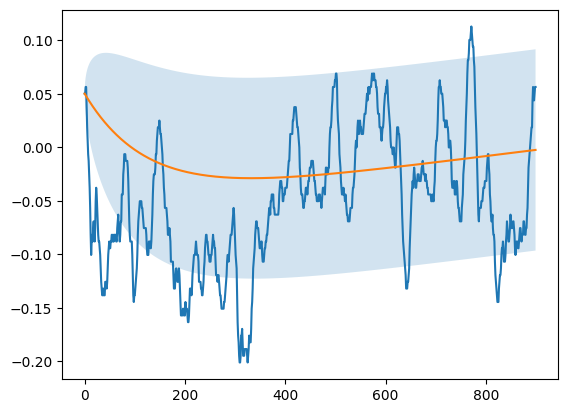

In [119]:
idx = 0
plt.plot(ts, dfs['y_test'].iloc[idx])
plt.plot(ts, y_pred_mean[idx])
plt.fill_between(ts, y_pred_mean[idx]-y_pred_std[idx], y_pred_mean[idx]+y_pred_std[idx], alpha=0.2)

## Call parameter model

In [120]:
piml_model.call_params(dfs['X_test'])[idx]

<tf.Tensor: shape=(8,), dtype=float64, numpy=
array([ 6.74933722e-01, -6.74258083e-04,  1.00000000e-03,  1.25309144e+02,
        1.67630405e+03,  1.19193728e-02, -3.87138892e-04,  4.69311521e-07])>

In [12]:
piml_model.st_process.param_names 

ListWrapper(['theta_0', 'omega_0', 's_theta_0', 'cov_theta_omega_0', 's_omega_0', 'tau', 'kappa', 'D', 'q', 'r'])

## Synthetic Sample generation

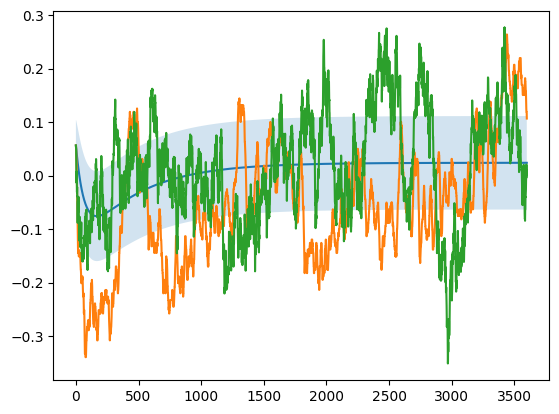

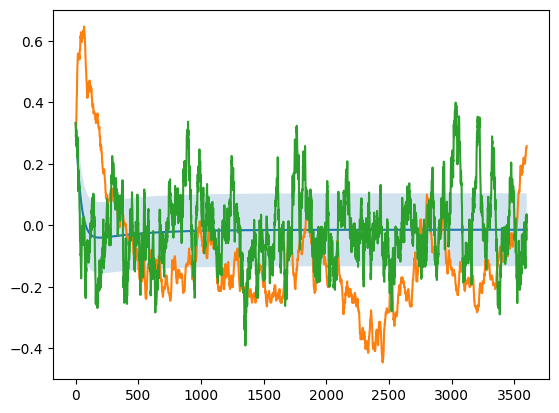

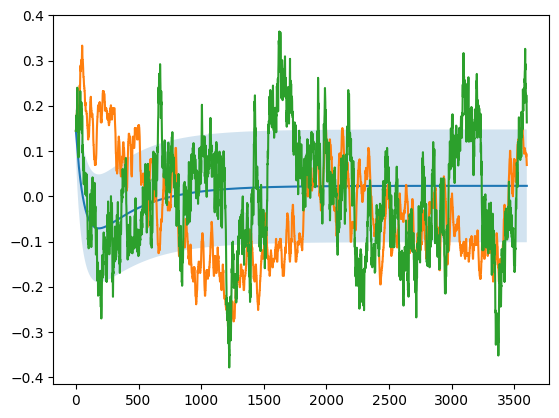

In [34]:
rand_samples = piml_model.generate_sample([dfs['X_test'], dfs['Z_test']], rolling=False)

for idx,sam in enumerate(rand_samples[:3]):
    plt.plot(ts, y_pred_mean[idx])
    plt.fill_between(ts, y_pred_mean[idx]-y_pred_std[idx], y_pred_mean[idx]+y_pred_std[idx], alpha=0.2)
    
    plt.plot(ts, dfs['y_test'].iloc[idx])
    plt.plot(ts, sam)
    
    plt.show()

## Benchmarking performance

In [92]:
dp_model = ml_models.DailyProfileModel()
dp_model.fit(dfs['y_train'])

y_dp_mean = dp_model(dfs['y_test']).mean()
y_dp_std = dp_model(dfs['y_test']).stddev()

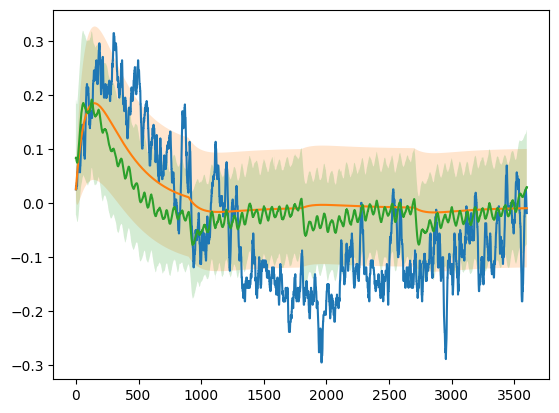

In [93]:
idx = 0
plt.plot(ts, dfs['y_test'].iloc[idx])

plt.plot(ts, y_pred_mean[idx], c='C1')
plt.fill_between(ts, y_pred_mean[idx]-y_pred_std[idx], y_pred_mean[idx]+y_pred_std[idx], alpha=0.2, fc='C1')

plt.plot(ts, y_dp_mean[idx], c='C2')
plt.fill_between(ts, y_dp_mean[idx]-y_dp_std[idx], y_dp_mean[idx]+y_dp_std[idx], alpha=0.2, fc='C2')


In [94]:
perf_loglike = pd.DataFrame(index=range(dfs['y_test'].shape[0]),
                            columns=['Daily profile', 'PIML'])

perf_loglike.loc[:,'Daily profile'] = negloglik(dfs['y_test'],dp_model(dfs['y_test']))
perf_loglike.loc[:,'PIML'] = negloglik(dfs['y_test'], piml_model([dfs['X_test'],dfs['Z_test']]))

perf_loglike

,Daily profile,PIML
0,-2793.314626,-2835.833893
1,-3285.694736,-1660.546990
2,-913.926198,-2398.666237
3,-2114.559711,-2714.902927
4,-2063.849936,-1904.676312
...,...,...
720,-3979.166904,-2899.863465
721,-1526.624648,-1739.576711
722,-4532.854411,-4320.729365
723,-1859.728093,-731.963376


<AxesSubplot:>

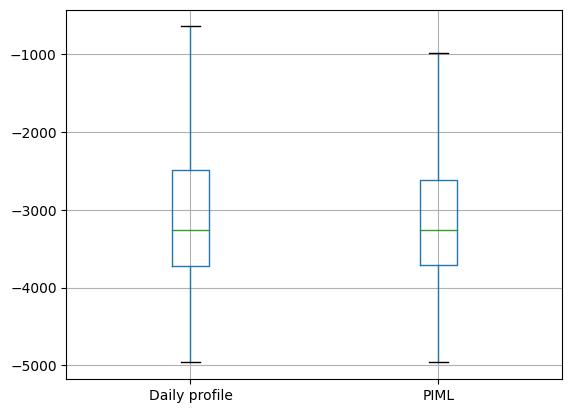

In [95]:
perf_loglike.boxplot(showfliers=False)

# HPO

In [ ]:
# Early stopping callback definition
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                        min_delta=1, restore_best_weights=1,
                                        mode='min')


# Define a Second-order model with hyper-parameters
fixed_model_hps = data_prep.prepare_fixed_hps(features=dfs['X_train'],
                                                ts=ts)
hyper_model = ml_models.SOHyperModel(**fixed_model_hps, loss=negloglik)   

# Initialize a hyper-parameter tuner
tuner = kt.RandomSearch(
    hyper_model,
    objective=kt.Objective('val_loss', direction='min'),
    max_trials=1,
    executions_per_trial=1,
    overwrite=True,
    directory='./test/',
    project_name="tuning"
)

# Tune hyper-parameters and use early stopping in ANN training
tuner.search([dfs['X_train'], dfs['Z_train']], dfs['y_train'],
             epochs=1, batch_size=128,
             validation_data=([dfs['X_val'], dfs['Z_val']],
                               dfs['y_val']),
             callbacks=[stop_early])


# Find best epoch for best HPs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.fit([dfs['X_train'], dfs['Z_train']], dfs['y_train'],
             epochs=1, batch_size=128)
model.save_weights('./test/best_model/')

In [ ]:
# Load model with best HPs
tuner=kt.Tuner(hypermodel=ml_models.SOHyperModel(**fixed_model_hps, loss=negloglik),
                                                directory='./test/',
                                                oracle=kt.Oracle(),
                                                project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.load_weights('./test/best_model/').expect_partial()

model([dfs['X_test'], dfs['Z_test']]).mean()